In [1]:
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import random
import keras

from scipy.io import loadmat
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Activation, LSTM, Bidirectional, GRU
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.utils import np_utils
from keras import optimizers, initializers
from keras import regularizers
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [2]:
#其實model.fit本來就會回傳記錄曲線圖
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'center right')
    plt.show()

In [3]:
data = np.load('6_action_training_data_v4.npy', allow_pickle=True)
x_train = data.item().get('x_train')
y_train = data.item().get('y_train')
x_valid = data.item().get('x_valid')
y_valid = data.item().get('y_valid')
x_test = data.item().get('x_test')
y_test = data.item().get('y_test')

train_ratio = 0.8
valid_ratio = 0.9
'''
total = x_data.shape[0]
x_train = x_data[0:int(train_ratio*total), :, :]
y_train = y_data[0:int(train_ratio*total)]
x_valid = x_data[int(train_ratio*total):int(valid_ratio*total), :, :]
y_valid = y_data[int(train_ratio*total):int(valid_ratio*total)]
x_test = x_data[int(valid_ratio*total):total, :, :]
y_test = y_data[int(valid_ratio*total):total]
'''

print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1237, 32, 36)
x_valid shape: (132, 32, 36)
x_test shape: (134, 32, 36)
y_train shape: (1237,)
y_valid shape: (132,)
y_test shape: (134,)


In [4]:
y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)
y_test = np_utils.to_categorical(y_test)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(1237, 6)
(132, 6)
(134, 6)


In [5]:
def action_classfier(shape, classes=6):
    X_input = Input((shape[1], shape[2]))
    
    X = Bidirectional(GRU(300, 
                           kernel_initializer=initializers.glorot_uniform(seed=0), 
                           recurrent_initializer=initializers.orthogonal(seed=0), return_sequences=True))(X_input)
    X = Bidirectional(GRU(300, 
                           kernel_initializer=initializers.glorot_uniform(seed=0), 
                           recurrent_initializer=initializers.orthogonal(seed=0), return_sequences=False))(X)
    X = BatchNormalization(epsilon=0.00001)(X)
    X = Dropout(0.75)(X)
    X = Dense(600, activation='relu', kernel_initializer=initializers.he_uniform(seed=0))(X)
    X = Dense(classes, activation='softmax', kernel_initializer=initializers.glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name='Fall Down Recognizer')
    
    return model

In [6]:
model = action_classfier(x_train.shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 36)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32, 600)           606600    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 600)               1621800   
_________________________________________________________________
batch_normalization_1 (Batch (None, 600)               2400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 600)               360600    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3606      
Total para

In [7]:
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.0, epsilon=None, decay=0.9)
model.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
train_history = model.fit(
    x_train, 
    y_train, 
    epochs=2000, 
    batch_size=150,
    validation_data=(x_valid, y_valid)
)

Train on 1237 samples, validate on 132 samples
Epoch 1/2000
1237/1237 [==============================] - 7s 5ms/step - loss: 2.6846 - acc: 0.3816 - val_loss: 1.5651 - val_acc: 0.6364
Epoch 2/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 1.7707 - acc: 0.5344 - val_loss: 1.1351 - val_acc: 0.7197
Epoch 3/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 1.4083 - acc: 0.6281 - val_loss: 1.1655 - val_acc: 0.6667
Epoch 4/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 1.3367 - acc: 0.6136 - val_loss: 1.3974 - val_acc: 0.5455
Epoch 5/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 1.1231 - acc: 0.6734 - val_loss: 1.3266 - val_acc: 0.6591
Epoch 6/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 1.0752 - acc: 0.6880 - val_loss: 1.1404 - val_acc: 0.5909
Epoch 7/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 1.0994 - acc: 0.6831 - val_loss: 2.9189 - val_acc: 0.4242
E

Epoch 120/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1575 - acc: 0.9636 - val_loss: 2.8892 - val_acc: 0.6212
Epoch 121/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1463 - acc: 0.9636 - val_loss: 3.1394 - val_acc: 0.6439
Epoch 122/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1450 - acc: 0.9669 - val_loss: 2.6980 - val_acc: 0.6667
Epoch 123/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1409 - acc: 0.9660 - val_loss: 2.8187 - val_acc: 0.6667
Epoch 124/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1625 - acc: 0.9612 - val_loss: 2.8190 - val_acc: 0.6591
Epoch 125/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1655 - acc: 0.9596 - val_loss: 2.5675 - val_acc: 0.6818
Epoch 126/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1713 - acc: 0.9563 - val_loss: 2.9714 - val_acc: 0.6061
Epoch 127/2000
1237/1237 [========

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1155 - acc: 0.9717 - val_loss: 2.7561 - val_acc: 0.6818
Epoch 239/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1216 - acc: 0.9709 - val_loss: 2.9703 - val_acc: 0.6970
Epoch 240/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1258 - acc: 0.9677 - val_loss: 2.8461 - val_acc: 0.6818
Epoch 241/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1202 - acc: 0.9709 - val_loss: 2.9937 - val_acc: 0.6818
Epoch 242/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1218 - acc: 0.9717 - val_loss: 3.1330 - val_acc: 0.6818
Epoch 243/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1348 - acc: 0.9693 - val_loss: 2.5991 - val_acc: 0.6818
Epoch 244/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1757 - acc: 0.9563 - val_loss: 2.8456 - val_acc: 0.6894
Epoch 245/2000
1237/1237 [=======================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1313 - acc: 0.9669 - val_loss: 3.1261 - val_acc: 0.6970
Epoch 357/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1352 - acc: 0.9644 - val_loss: 3.2630 - val_acc: 0.6667
Epoch 358/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1253 - acc: 0.9701 - val_loss: 2.7950 - val_acc: 0.7045
Epoch 359/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1553 - acc: 0.9628 - val_loss: 3.0511 - val_acc: 0.6894
Epoch 360/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1332 - acc: 0.9677 - val_loss: 2.8810 - val_acc: 0.7121
Epoch 361/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1443 - acc: 0.9628 - val_loss: 3.7523 - val_acc: 0.6591
Epoch 362/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1683 - acc: 0.9580 - val_loss: 2.7129 - val_acc: 0.7273
Epoch 363/2000
1237/1237 [=======================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1319 - acc: 0.9652 - val_loss: 3.1436 - val_acc: 0.6894
Epoch 475/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1356 - acc: 0.9669 - val_loss: 2.6489 - val_acc: 0.7273
Epoch 476/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1383 - acc: 0.9669 - val_loss: 3.1753 - val_acc: 0.7045
Epoch 477/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1931 - acc: 0.9523 - val_loss: 3.2046 - val_acc: 0.6667
Epoch 478/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1343 - acc: 0.9660 - val_loss: 3.0504 - val_acc: 0.6742
Epoch 479/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1177 - acc: 0.9717 - val_loss: 2.9503 - val_acc: 0.6818
Epoch 480/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1285 - acc: 0.9685 - val_loss: 2.3338 - val_acc: 0.6970
Epoch 481/2000
1237/1237 [=======================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1429 - acc: 0.9620 - val_loss: 3.0210 - val_acc: 0.7045
Epoch 593/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1305 - acc: 0.9669 - val_loss: 2.8027 - val_acc: 0.7045
Epoch 594/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1288 - acc: 0.9677 - val_loss: 2.7385 - val_acc: 0.6818
Epoch 595/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1240 - acc: 0.9701 - val_loss: 2.8507 - val_acc: 0.6894
Epoch 596/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1221 - acc: 0.9701 - val_loss: 2.9309 - val_acc: 0.6970
Epoch 597/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1183 - acc: 0.9709 - val_loss: 2.9308 - val_acc: 0.6742
Epoch 598/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1216 - acc: 0.9717 - val_loss: 2.9794 - val_acc: 0.6894
Epoch 599/2000
1237/1237 [=======================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1561 - acc: 0.9628 - val_loss: 3.0916 - val_acc: 0.6894
Epoch 711/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1487 - acc: 0.9644 - val_loss: 3.4286 - val_acc: 0.6136
Epoch 712/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1755 - acc: 0.9596 - val_loss: 3.0858 - val_acc: 0.6515
Epoch 713/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1257 - acc: 0.9693 - val_loss: 2.9650 - val_acc: 0.6894
Epoch 714/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1198 - acc: 0.9709 - val_loss: 2.9140 - val_acc: 0.6667
Epoch 715/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1246 - acc: 0.9693 - val_loss: 2.9286 - val_acc: 0.6591
Epoch 716/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1181 - acc: 0.9717 - val_loss: 2.9113 - val_acc: 0.6667
Epoch 717/2000
1237/1237 [=======================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1150 - acc: 0.9709 - val_loss: 2.6079 - val_acc: 0.6742
Epoch 829/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1187 - acc: 0.9717 - val_loss: 2.6959 - val_acc: 0.6742
Epoch 830/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1188 - acc: 0.9717 - val_loss: 2.8476 - val_acc: 0.6894
Epoch 831/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1196 - acc: 0.9717 - val_loss: 2.9889 - val_acc: 0.6970
Epoch 832/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1188 - acc: 0.9709 - val_loss: 3.1973 - val_acc: 0.6667
Epoch 833/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1241 - acc: 0.9701 - val_loss: 2.8318 - val_acc: 0.6894
Epoch 834/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1206 - acc: 0.9709 - val_loss: 3.0332 - val_acc: 0.6970
Epoch 835/2000
1237/1237 [=======================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1190 - acc: 0.9717 - val_loss: 2.9792 - val_acc: 0.6667
Epoch 947/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1187 - acc: 0.9717 - val_loss: 3.1062 - val_acc: 0.6818
Epoch 948/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1152 - acc: 0.9717 - val_loss: 3.1501 - val_acc: 0.6818
Epoch 949/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1178 - acc: 0.9717 - val_loss: 3.0604 - val_acc: 0.6818
Epoch 950/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1137 - acc: 0.9717 - val_loss: 3.0674 - val_acc: 0.6742
Epoch 951/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1161 - acc: 0.9717 - val_loss: 3.0315 - val_acc: 0.6667
Epoch 952/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1245 - acc: 0.9709 - val_loss: 3.0497 - val_acc: 0.6591
Epoch 953/2000
1237/1237 [=======================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1357 - acc: 0.9652 - val_loss: 3.3832 - val_acc: 0.6591
Epoch 1065/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1692 - acc: 0.9644 - val_loss: 3.1268 - val_acc: 0.6667
Epoch 1066/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1444 - acc: 0.9669 - val_loss: 3.6466 - val_acc: 0.6212
Epoch 1067/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1356 - acc: 0.9669 - val_loss: 3.0237 - val_acc: 0.7045
Epoch 1068/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1222 - acc: 0.9685 - val_loss: 3.1608 - val_acc: 0.7045
Epoch 1069/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1356 - acc: 0.9693 - val_loss: 3.1139 - val_acc: 0.7045
Epoch 1070/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1286 - acc: 0.9709 - val_loss: 3.2212 - val_acc: 0.7197
Epoch 1071/2000
1237/1237 [================

1237/1237 [==============================] - 2s 2ms/step - loss: 0.1217 - acc: 0.9717 - val_loss: 3.6106 - val_acc: 0.6742
Epoch 1124/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1172 - acc: 0.9717 - val_loss: 3.5874 - val_acc: 0.6742
Epoch 1125/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1165 - acc: 0.9717 - val_loss: 3.4546 - val_acc: 0.6894
Epoch 1126/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1140 - acc: 0.9717 - val_loss: 3.4061 - val_acc: 0.7045
Epoch 1127/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1316 - acc: 0.9677 - val_loss: 3.6326 - val_acc: 0.6667
Epoch 1128/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1291 - acc: 0.9660 - val_loss: 3.7006 - val_acc: 0.6667
Epoch 1129/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1191 - acc: 0.9709 - val_loss: 3.2125 - val_acc: 0.7121
Epoch 1130/2000
1237/1237 [================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1190 - acc: 0.9717 - val_loss: 3.3516 - val_acc: 0.6591
Epoch 1183/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1257 - acc: 0.9693 - val_loss: 3.2901 - val_acc: 0.7045
Epoch 1184/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1217 - acc: 0.9701 - val_loss: 3.4181 - val_acc: 0.6894
Epoch 1185/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1241 - acc: 0.9717 - val_loss: 3.5022 - val_acc: 0.6742
Epoch 1186/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1177 - acc: 0.9717 - val_loss: 3.5766 - val_acc: 0.6667
Epoch 1187/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1354 - acc: 0.9693 - val_loss: 3.2890 - val_acc: 0.6818
Epoch 1188/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1186 - acc: 0.9701 - val_loss: 3.2697 - val_acc: 0.7121
Epoch 1189/2000
1237/1237 [================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1194 - acc: 0.9717 - val_loss: 3.2647 - val_acc: 0.6894
Epoch 1242/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1172 - acc: 0.9709 - val_loss: 3.2013 - val_acc: 0.6970
Epoch 1243/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1202 - acc: 0.9709 - val_loss: 3.4284 - val_acc: 0.6515
Epoch 1244/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1189 - acc: 0.9717 - val_loss: 3.4137 - val_acc: 0.6742
Epoch 1245/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1196 - acc: 0.9717 - val_loss: 3.5083 - val_acc: 0.6742
Epoch 1246/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1157 - acc: 0.9709 - val_loss: 3.5168 - val_acc: 0.6818
Epoch 1247/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1165 - acc: 0.9717 - val_loss: 3.4514 - val_acc: 0.6515
Epoch 1248/2000
1237/1237 [================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1226 - acc: 0.9685 - val_loss: 3.4144 - val_acc: 0.6818
Epoch 1301/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1239 - acc: 0.9693 - val_loss: 3.7741 - val_acc: 0.6364
Epoch 1302/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1158 - acc: 0.9717 - val_loss: 3.7234 - val_acc: 0.6439
Epoch 1303/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1386 - acc: 0.9669 - val_loss: 3.9380 - val_acc: 0.6136
Epoch 1304/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1287 - acc: 0.9701 - val_loss: 3.7604 - val_acc: 0.6288
Epoch 1305/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1367 - acc: 0.9685 - val_loss: 3.4645 - val_acc: 0.6515
Epoch 1306/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1218 - acc: 0.9693 - val_loss: 3.8709 - val_acc: 0.6288
Epoch 1307/2000
1237/1237 [================

1237/1237 [==============================] - 2s 2ms/step - loss: 0.1163 - acc: 0.9709 - val_loss: 3.5730 - val_acc: 0.6667
Epoch 1360/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1337 - acc: 0.9669 - val_loss: 3.6560 - val_acc: 0.6894
Epoch 1361/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.2038 - acc: 0.9547 - val_loss: 3.4924 - val_acc: 0.6667
Epoch 1362/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1289 - acc: 0.9652 - val_loss: 3.4187 - val_acc: 0.6667
Epoch 1363/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1296 - acc: 0.9660 - val_loss: 3.5166 - val_acc: 0.6515
Epoch 1364/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1217 - acc: 0.9709 - val_loss: 3.4710 - val_acc: 0.6667
Epoch 1365/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1339 - acc: 0.9685 - val_loss: 3.3640 - val_acc: 0.6136
Epoch 1366/2000
1237/1237 [================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1570 - acc: 0.9652 - val_loss: 4.1480 - val_acc: 0.5682
Epoch 1419/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1391 - acc: 0.9669 - val_loss: 3.8666 - val_acc: 0.6288
Epoch 1420/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1215 - acc: 0.9709 - val_loss: 3.9675 - val_acc: 0.6288
Epoch 1421/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1192 - acc: 0.9709 - val_loss: 3.6291 - val_acc: 0.6667
Epoch 1422/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1193 - acc: 0.9709 - val_loss: 3.6719 - val_acc: 0.6439
Epoch 1423/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1214 - acc: 0.9701 - val_loss: 3.7513 - val_acc: 0.6439
Epoch 1424/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1264 - acc: 0.9685 - val_loss: 4.0453 - val_acc: 0.6364
Epoch 1425/2000
1237/1237 [================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1183 - acc: 0.9709 - val_loss: 3.3153 - val_acc: 0.6818
Epoch 1478/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1155 - acc: 0.9717 - val_loss: 3.3610 - val_acc: 0.6818
Epoch 1479/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1159 - acc: 0.9717 - val_loss: 3.4185 - val_acc: 0.6591
Epoch 1480/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1163 - acc: 0.9717 - val_loss: 3.4220 - val_acc: 0.6591
Epoch 1481/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1145 - acc: 0.9717 - val_loss: 3.7135 - val_acc: 0.6515
Epoch 1482/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1175 - acc: 0.9709 - val_loss: 3.5616 - val_acc: 0.6818
Epoch 1483/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1349 - acc: 0.9652 - val_loss: 3.9390 - val_acc: 0.6136
Epoch 1484/2000
1237/1237 [================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1311 - acc: 0.9669 - val_loss: 3.6328 - val_acc: 0.6667
Epoch 1537/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1241 - acc: 0.9701 - val_loss: 3.3826 - val_acc: 0.6515
Epoch 1538/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1243 - acc: 0.9709 - val_loss: 3.7006 - val_acc: 0.6439
Epoch 1539/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1263 - acc: 0.9677 - val_loss: 4.0804 - val_acc: 0.5833
Epoch 1540/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1468 - acc: 0.9652 - val_loss: 3.9742 - val_acc: 0.6212
Epoch 1541/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1312 - acc: 0.9685 - val_loss: 3.9133 - val_acc: 0.6288
Epoch 1542/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1188 - acc: 0.9709 - val_loss: 3.8362 - val_acc: 0.5985
Epoch 1543/2000
1237/1237 [================

1237/1237 [==============================] - 2s 2ms/step - loss: 0.1618 - acc: 0.9604 - val_loss: 3.2520 - val_acc: 0.6970
Epoch 1596/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1297 - acc: 0.9693 - val_loss: 2.7522 - val_acc: 0.7045
Epoch 1597/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1226 - acc: 0.9701 - val_loss: 3.0394 - val_acc: 0.6667
Epoch 1598/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1153 - acc: 0.9717 - val_loss: 2.9943 - val_acc: 0.6667
Epoch 1599/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1162 - acc: 0.9717 - val_loss: 2.8083 - val_acc: 0.6970
Epoch 1600/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1167 - acc: 0.9717 - val_loss: 3.1159 - val_acc: 0.6742
Epoch 1601/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1162 - acc: 0.9717 - val_loss: 3.4064 - val_acc: 0.6667
Epoch 1602/2000
1237/1237 [================

1237/1237 [==============================] - 2s 2ms/step - loss: 0.1294 - acc: 0.9693 - val_loss: 3.3396 - val_acc: 0.6667
Epoch 1655/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1240 - acc: 0.9693 - val_loss: 3.6170 - val_acc: 0.6591
Epoch 1656/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1163 - acc: 0.9701 - val_loss: 3.8087 - val_acc: 0.6212
Epoch 1657/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1193 - acc: 0.9701 - val_loss: 2.9797 - val_acc: 0.7121
Epoch 1658/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1248 - acc: 0.9709 - val_loss: 3.2153 - val_acc: 0.6970
Epoch 1659/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1170 - acc: 0.9717 - val_loss: 3.4187 - val_acc: 0.6667
Epoch 1660/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1177 - acc: 0.9709 - val_loss: 3.4792 - val_acc: 0.6591
Epoch 1661/2000
1237/1237 [================

1237/1237 [==============================] - 2s 2ms/step - loss: 0.1243 - acc: 0.9685 - val_loss: 3.8100 - val_acc: 0.6591
Epoch 1714/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1483 - acc: 0.9660 - val_loss: 3.8212 - val_acc: 0.6742
Epoch 1715/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1308 - acc: 0.9709 - val_loss: 3.7632 - val_acc: 0.6742
Epoch 1716/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1334 - acc: 0.9701 - val_loss: 3.6971 - val_acc: 0.6818
Epoch 1717/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1322 - acc: 0.9685 - val_loss: 3.8006 - val_acc: 0.6212
Epoch 1718/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1254 - acc: 0.9677 - val_loss: 3.7168 - val_acc: 0.6136
Epoch 1719/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1243 - acc: 0.9685 - val_loss: 4.4110 - val_acc: 0.6136
Epoch 1720/2000
1237/1237 [================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1264 - acc: 0.9701 - val_loss: 3.1853 - val_acc: 0.6742
Epoch 1773/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1220 - acc: 0.9701 - val_loss: 3.4924 - val_acc: 0.6212
Epoch 1774/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1215 - acc: 0.9701 - val_loss: 3.3509 - val_acc: 0.6591
Epoch 1775/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1178 - acc: 0.9717 - val_loss: 3.3951 - val_acc: 0.6742
Epoch 1776/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1210 - acc: 0.9701 - val_loss: 3.3428 - val_acc: 0.6591
Epoch 1777/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1202 - acc: 0.9709 - val_loss: 3.6465 - val_acc: 0.6515
Epoch 1778/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1225 - acc: 0.9709 - val_loss: 3.8307 - val_acc: 0.6364
Epoch 1779/2000
1237/1237 [================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1178 - acc: 0.9717 - val_loss: 3.9311 - val_acc: 0.6742
Epoch 1832/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1187 - acc: 0.9717 - val_loss: 3.9652 - val_acc: 0.6667
Epoch 1833/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1167 - acc: 0.9717 - val_loss: 3.8681 - val_acc: 0.6742
Epoch 1834/2000
1237/1237 [==============================] - 3s 2ms/step - loss: 0.1157 - acc: 0.9717 - val_loss: 3.9595 - val_acc: 0.6667
Epoch 1835/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1191 - acc: 0.9717 - val_loss: 3.9265 - val_acc: 0.6667
Epoch 1836/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1184 - acc: 0.9709 - val_loss: 3.8319 - val_acc: 0.6591
Epoch 1837/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1175 - acc: 0.9717 - val_loss: 3.7101 - val_acc: 0.6591
Epoch 1838/2000
1237/1237 [================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1192 - acc: 0.9717 - val_loss: 3.5326 - val_acc: 0.6364
Epoch 1891/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1217 - acc: 0.9693 - val_loss: 3.7329 - val_acc: 0.6364
Epoch 1892/2000
1237/1237 [==============================] - 2s 2ms/step - loss: 0.1167 - acc: 0.9717 - val_loss: 3.9410 - val_acc: 0.6364
Epoch 1893/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1186 - acc: 0.9709 - val_loss: 3.7483 - val_acc: 0.6439
Epoch 1894/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1167 - acc: 0.9717 - val_loss: 3.8016 - val_acc: 0.6439
Epoch 1895/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1190 - acc: 0.9709 - val_loss: 3.6674 - val_acc: 0.6439
Epoch 1896/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1198 - acc: 0.9717 - val_loss: 3.6001 - val_acc: 0.6818
Epoch 1897/2000
1237/1237 [================

1237/1237 [==============================] - 2s 1ms/step - loss: 0.1163 - acc: 0.9717 - val_loss: 4.4322 - val_acc: 0.6061
Epoch 1950/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1178 - acc: 0.9717 - val_loss: 4.1604 - val_acc: 0.6136
Epoch 1951/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1161 - acc: 0.9717 - val_loss: 4.0318 - val_acc: 0.6288
Epoch 1952/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1288 - acc: 0.9677 - val_loss: 4.1494 - val_acc: 0.6212
Epoch 1953/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1239 - acc: 0.9685 - val_loss: 3.8743 - val_acc: 0.6667
Epoch 1954/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1202 - acc: 0.9709 - val_loss: 4.1327 - val_acc: 0.6439
Epoch 1955/2000
1237/1237 [==============================] - 2s 1ms/step - loss: 0.1200 - acc: 0.9709 - val_loss: 4.3303 - val_acc: 0.6288
Epoch 1956/2000
1237/1237 [================

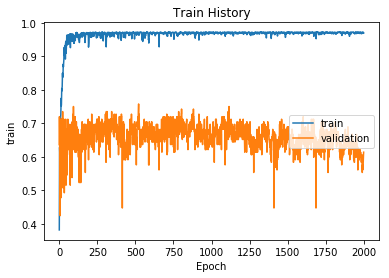

In [9]:
show_train_history(train_history, 'acc', 'val_acc')

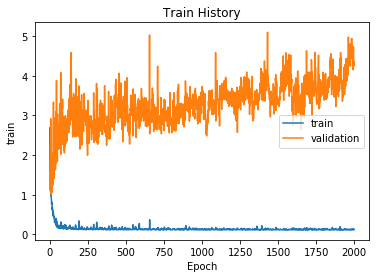

In [10]:
show_train_history(train_history, 'loss', 'val_loss')

In [11]:
score = model.evaluate(x_test, y_test, batch_size=100, verbose=0)
print('Total loss on Testing Set:', score[0])
print('Accuracy of Testing Set:', score[1])

Total loss on Testing Set: 3.3470032001609233
Accuracy of Testing Set: 0.7089552114258951


In [12]:
model.save('my_model.h5')

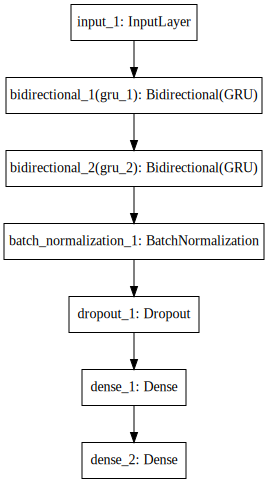

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#產生模型結構圖.png
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

SVG(model_to_dot(model).create(prog='dot', format='svg'))